# SANTANDER EDA AND PREDICTION

In [1]:
#for data vizualisation and data pre-processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6) 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#for encoding
from sklearn.preprocessing import LabelEncoder

# for model selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# for cross validation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
from collections import defaultdict

# for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


https://www.kaggle.com/gpreda/santander-eda-and-prediction

In [2]:
# Calibrate the number of rows to not crash the kernel 
df           = pd.read_csv("train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str})
test           = pd.read_csv("test_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str})

# Format to datetime data,maybe the month of the year is important to purchase

df["month"] = pd.DatetimeIndex(df["fecha_dato"]).month
df["age"]   = pd.to_numeric(df["age"], errors="coerce")
# Not very sure just to keep with unique_ids 'cause principal id is fecha_dato + ncodpers and if we
# eliminate repeated ncodpers we lose some important information.
#We take unique_ids and unique fecha_datos just to play forward.
unique_ids   = pd.Series(df["ncodpers"].unique())
unique_fecha_dato = df["fecha_dato"].unique()
df.head()


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,month
0,1/28/2015,1050622,N,ES,H,23.0,8/10/2012,0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1
1,1/28/2015,1050492,N,ES,V,25.0,8/10/2012,0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1
2,1/28/2015,1050571,N,ES,H,23.0,8/10/2012,0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1
3,1/28/2015,1050915,N,ES,H,37.0,8/10/2012,0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1
4,1/28/2015,1050732,N,ES,H,23.0,8/10/2012,0,35,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1


In [3]:
print(df.shape,test.shape)

(50000, 49) (38171, 24)


In [4]:
df.isnull().sum()

fecha_dato                   0
ncodpers                     0
ind_empleado               109
pais_residencia            109
sexo                       109
age                        109
fecha_alta                 109
ind_nuevo                  109
antiguedad                   0
indrel                     109
ult_fec_cli_1t           49910
indrel_1mes                544
tiprel_1mes                544
indresi                    109
indext                     109
conyuemp                 49995
canal_entrada              683
indfall                    109
tipodom                    109
cod_prov                   340
nomprov                    340
ind_actividad_cliente      109
renta                    10375
segmento                   694
ind_ahor_fin_ult1            0
ind_aval_fin_ult1            0
ind_cco_fin_ult1             0
ind_cder_fin_ult1            0
ind_cno_fin_ult1             0
ind_ctju_fin_ult1            0
ind_ctma_fin_ult1            0
ind_ctop_fin_ult1            0
ind_ctpp

In [5]:
test.isnull().sum()

fecha_dato                   0
ncodpers                     0
ind_empleado                 0
pais_residencia              0
sexo                         0
age                          0
fecha_alta                   0
ind_nuevo                    0
antiguedad                   0
indrel                       0
ult_fec_cli_1t           38127
indrel_1mes                  0
tiprel_1mes                  0
indresi                      0
indext                       0
conyuemp                 38170
canal_entrada                0
indfall                      0
tipodom                      0
cod_prov                    20
nomprov                     20
ind_actividad_cliente        0
renta                        0
segmento                     1
dtype: int64

# DATA PREPROCESSING

In [6]:
train_unique_customers = set(df.ncodpers.unique())
test_unique_customers = set(test.ncodpers.unique())
print("Number of customers in train : ", len(train_unique_customers))
print("Number of customers in test : ", len(test_unique_customers))
print("Number of common customers : ", len(train_unique_customers.intersection(test_unique_customers)))
#finding out the number of unique customers in train and test and number of common customers in both
#because for increasing our accuracy this is what we need to focus on

Number of customers in train :  48695
Number of customers in test :  38171
Number of common customers :  2237


In [7]:
df.dtypes

fecha_dato                object
ncodpers                   int64
ind_empleado              object
pais_residencia           object
sexo                      object
age                      float64
fecha_alta                object
ind_nuevo                 object
antiguedad                object
indrel                   float64
ult_fec_cli_1t            object
indrel_1mes               object
tiprel_1mes               object
indresi                   object
indext                    object
conyuemp                  object
canal_entrada             object
indfall                   object
tipodom                  float64
cod_prov                 float64
nomprov                   object
ind_actividad_cliente    float64
renta                    float64
segmento                  object
ind_ahor_fin_ult1          int64
ind_aval_fin_ult1          int64
ind_cco_fin_ult1           int64
ind_cder_fin_ult1          int64
ind_cno_fin_ult1           int64
ind_ctju_fin_ult1          int64
ind_ctma_f

In [8]:
# Change datatype
# We need to convert datatypes into suitable format
df["age"]   = pd.to_numeric(df["age"], errors="coerce") 
df["antiguedad"]   = pd.to_numeric(df["antiguedad"], errors="coerce") 
df["indrel_1mes"]   = pd.to_numeric(df["indrel_1mes"], errors="coerce") 
#coerce means the errors will be filled as NaN values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fecha_dato             50000 non-null  object 
 1   ncodpers               50000 non-null  int64  
 2   ind_empleado           49891 non-null  object 
 3   pais_residencia        49891 non-null  object 
 4   sexo                   49891 non-null  object 
 5   age                    49891 non-null  float64
 6   fecha_alta             49891 non-null  object 
 7   ind_nuevo              49891 non-null  object 
 8   antiguedad             49891 non-null  float64
 9   indrel                 49891 non-null  float64
 10  ult_fec_cli_1t         90 non-null     object 
 11  indrel_1mes            49452 non-null  float64
 12  tiprel_1mes            49456 non-null  object 
 13  indresi                49891 non-null  object 
 14  indext                 49891 non-null  object 
 15  co

In [10]:
df.isnull().sum()

fecha_dato                   0
ncodpers                     0
ind_empleado               109
pais_residencia            109
sexo                       109
age                        109
fecha_alta                 109
ind_nuevo                  109
antiguedad                 109
indrel                     109
ult_fec_cli_1t           49910
indrel_1mes                548
tiprel_1mes                544
indresi                    109
indext                     109
conyuemp                 49995
canal_entrada              683
indfall                    109
tipodom                    109
cod_prov                   340
nomprov                    340
ind_actividad_cliente      109
renta                    10375
segmento                   694
ind_ahor_fin_ult1            0
ind_aval_fin_ult1            0
ind_cco_fin_ult1             0
ind_cder_fin_ult1            0
ind_cno_fin_ult1             0
ind_ctju_fin_ult1            0
ind_ctma_fin_ult1            0
ind_ctop_fin_ult1            0
ind_ctpp

There are two columns ("ult_fec_cli_1t", "conyuemp") with almost all values are missing. We are going to delete them from the dataframe.
We delete this because there are too many empty values if we try to fill them we have no basis on which we can do this
Thus we will be putting wrong datapoints in our dataset which is going to affect our model.


In [11]:
# Drop the columns with majority of missing values
df = df.drop(["ult_fec_cli_1t", "conyuemp"], axis=1) 

We are going to fill column:'renta' because it has 10000 which is 20 percent so we are going to fill it

In [12]:
#Impute missing values in the income column 
grouped        = df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"})
df.sort_values("nomprov",inplace=True)
df             = df.reset_index()
new_incomes    = new_incomes.reset_index()

df.loc[df.renta.isnull(),"renta"] = new_incomes.loc[df.renta.isnull(),"renta"].reset_index()
df.loc[df.renta.isnull(),"renta"] = df.loc[df.renta.notnull(),"renta"].median()
df.sort_values(by="fecha_dato",inplace=True)

In [13]:
df.head()

,index,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,month
32254,686,1/28/2015,1258037,N,ES,H,67.0,5/14/2014,0,14.0,...,0,0,0,0,0,0,0.0,0.0,1,1
47435,1866,1/28/2015,814768,N,ES,V,68.0,11/7/2008,0,80.0,...,0,0,0,0,0,0,0.0,0.0,0,1
14992,2112,1/28/2015,576712,N,ES,V,40.0,10/31/2005,0,117.0,...,1,0,0,0,1,0,0.0,0.0,0,1
47432,179,1/28/2015,1099132,N,ES,H,24.0,11/12/2012,0,32.0,...,0,0,0,0,0,0,0.0,0.0,0,1
32825,1412,1/28/2015,327741,N,ES,V,54.0,2/6/2002,0,161.0,...,0,0,0,0,0,0,0.0,0.0,0,1


In [14]:
df.isnull().sum()

index                      0
fecha_dato                 0
ncodpers                   0
ind_empleado             109
pais_residencia          109
sexo                     109
age                      109
fecha_alta               109
ind_nuevo                109
antiguedad               109
indrel                   109
indrel_1mes              548
tiprel_1mes              544
indresi                  109
indext                   109
canal_entrada            683
indfall                  109
tipodom                  109
cod_prov                 340
nomprov                  340
ind_actividad_cliente    109
renta                      0
segmento                 694
ind_ahor_fin_ult1          0
ind_aval_fin_ult1          0
ind_cco_fin_ult1           0
ind_cder_fin_ult1          0
ind_cno_fin_ult1           0
ind_ctju_fin_ult1          0
ind_ctma_fin_ult1          0
ind_ctop_fin_ult1          0
ind_ctpp_fin_ult1          0
ind_deco_fin_ult1          0
ind_deme_fin_ult1          0
ind_dela_fin_u

For other values only less than 2 percent of the values are missing 
So instead of filling them with values that may be not correct
we are going to drop the null values

In [15]:
# Dropping the null values
df = df.dropna(axis=0)

In [16]:
df.isnull().sum()

index                    0
fecha_dato               0
ncodpers                 0
ind_empleado             0
pais_residencia          0
sexo                     0
age                      0
fecha_alta               0
ind_nuevo                0
antiguedad               0
indrel                   0
indrel_1mes              0
tiprel_1mes              0
indresi                  0
indext                   0
canal_entrada            0
indfall                  0
tipodom                  0
cod_prov                 0
nomprov                  0
ind_actividad_cliente    0
renta                    0
segmento                 0
ind_ahor_fin_ult1        0
ind_aval_fin_ult1        0
ind_cco_fin_ult1         0
ind_cder_fin_ult1        0
ind_cno_fin_ult1         0
ind_ctju_fin_ult1        0
ind_ctma_fin_ult1        0
ind_ctop_fin_ult1        0
ind_ctpp_fin_ult1        0
ind_deco_fin_ult1        0
ind_deme_fin_ult1        0
ind_dela_fin_ult1        0
ind_ecue_fin_ult1        0
ind_fond_fin_ult1        0
i

In [17]:
df.shape

(49072, 48)

In [18]:
df.pais_residencia.value_counts()
# As we can see almost all values in this column has value from ES so we are going to take the value of ES only

ES    49072
Name: pais_residencia, dtype: int64

In [19]:
df = df.loc[lambda df: df.pais_residencia == "ES", :]

In [20]:
# Replacing all value which is less than zero in seniority with zero
df[df["antiguedad"]<0] = 0

In [21]:
# Add a new column of the total number of products per customer per month
df["tot_products"] = df.loc[:,"ind_ahor_fin_ult1":"ind_recibo_ult1"].sum(axis=1)
df["tot_products"]   = pd.to_numeric(df["tot_products"], errors="coerce") 

In [22]:
df.head()

,index,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,...,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,month,tot_products
32254,686,1/28/2015,1258037,N,ES,H,67.0,5/14/2014,0,14.0,...,0,0,0,0,0,0.0,0.0,1,1,2.0
47435,1866,1/28/2015,814768,N,ES,V,68.0,11/7/2008,0,80.0,...,0,0,0,0,0,0.0,0.0,0,1,2.0
14992,2112,1/28/2015,576712,N,ES,V,40.0,10/31/2005,0,117.0,...,0,0,0,1,0,0.0,0.0,0,1,4.0
47432,179,1/28/2015,1099132,N,ES,H,24.0,11/12/2012,0,32.0,...,0,0,0,0,0,0.0,0.0,0,1,1.0
32825,1412,1/28/2015,327741,N,ES,V,54.0,2/6/2002,0,161.0,...,0,0,0,0,0,0.0,0.0,0,1,1.0


# DATA VISUALIZATION 

Text(0, 0.5, 'Number of customers')

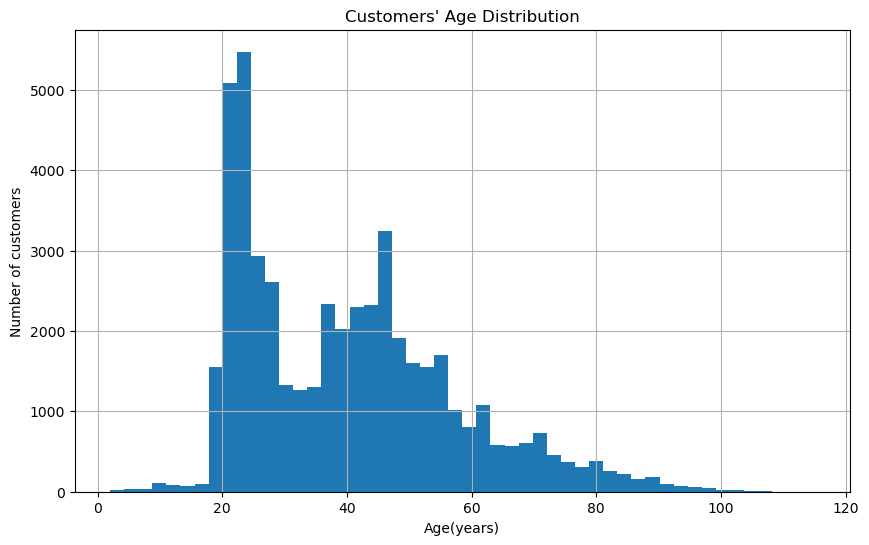

In [23]:
# Plot of number of customers versus age
df['age'].hist(bins=50)
plt.title("Customers' Age Distribution")
plt.xlabel("Age(years)")
plt.ylabel("Number of customers") 

In [24]:
# plotting average number pf customers between a slot of 10 years 

In [25]:
df.loc[df.age < 18,"age"]  = df.loc[(df.age >= 18) & (df.age <= 30),"age"].mean(skipna=True)
df.loc[df.age > 90,"age"] = df.loc[(df.age >= 30) & (df.age <= 90),"age"].mean(skipna=True)
df["age"].fillna(df["age"].mean(),inplace=True)
df["age"] = df["age"].astype(int)

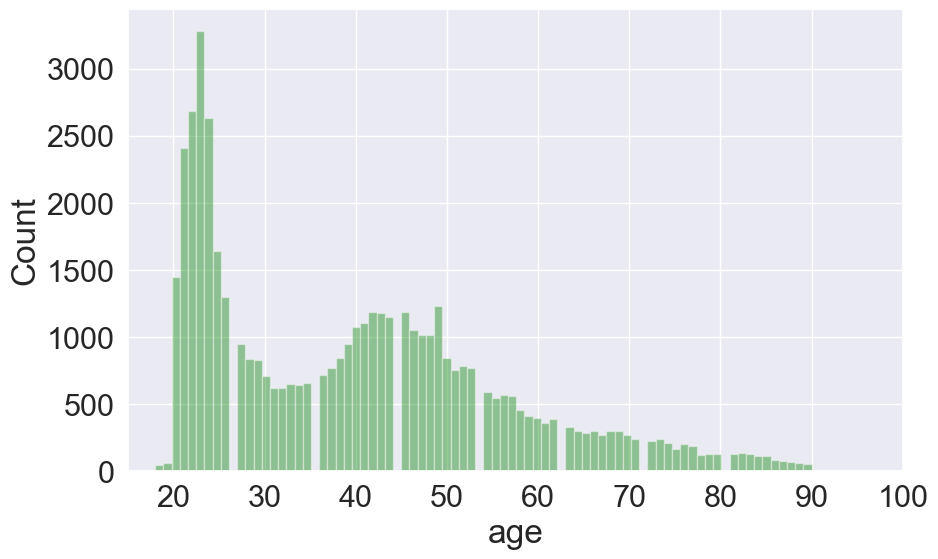

In [26]:
with sns.plotting_context("notebook",font_scale=2.0):
    sns.set_style("darkgrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="green",)
    plt.ylabel("Count")
    plt.xlim((15,100))


# Customers attraction by channel
The channels through which the customers were attracted to join.

<AxesSubplot:ylabel='canal_entrada'>

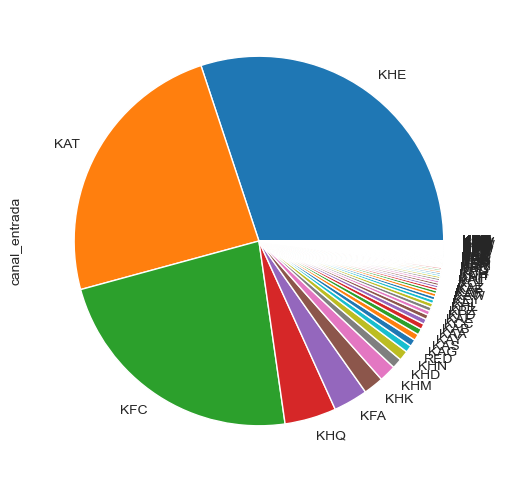

In [27]:
df["canal_entrada"].value_counts().plot(x=None, y=None, kind='pie') 
# The maximum of contribution is from channel KHE,KAT,KFC,KHQ,KFA

In [28]:
df['canal_entrada'].value_counts()

KHE    14760
KAT    11854
KFC    11301
KHQ     2213
KFA     1476
       ...  
KFM        1
KCV        1
KHA        1
KCO        1
KEK        1
Name: canal_entrada, Length: 129, dtype: int64

In [29]:
df_a = df.loc[:, ['sexo', 'ind_actividad_cliente']].join(df.loc[:, "ind_ahor_fin_ult1": "ind_recibo_ult1"])
df_a = df_a.groupby(['sexo', 'ind_actividad_cliente']).sum()
df_a = df_a.T

In [30]:
df_a.head(10)

sexo                        H               V        
ind_actividad_cliente     0.0     1.0     0.0     1.0
ind_ahor_fin_ult1         1.0     0.0     2.0     1.0
ind_aval_fin_ult1         0.0     0.0     0.0     0.0
ind_cco_fin_ult1       7998.0  7286.0  7456.0  9486.0
ind_cder_fin_ult1         2.0     3.0     1.0    17.0
ind_cno_fin_ult1         26.0  1610.0    29.0  2348.0
ind_ctju_fin_ult1        40.0   190.0    59.0   195.0
ind_ctma_fin_ult1        34.0   167.0    65.0   198.0
ind_ctop_fin_ult1       830.0  1713.0  1312.0  2629.0
ind_ctpp_fin_ult1       145.0   719.0   220.0  1098.0
ind_deco_fin_ult1         6.0    36.0     9.0    39.0

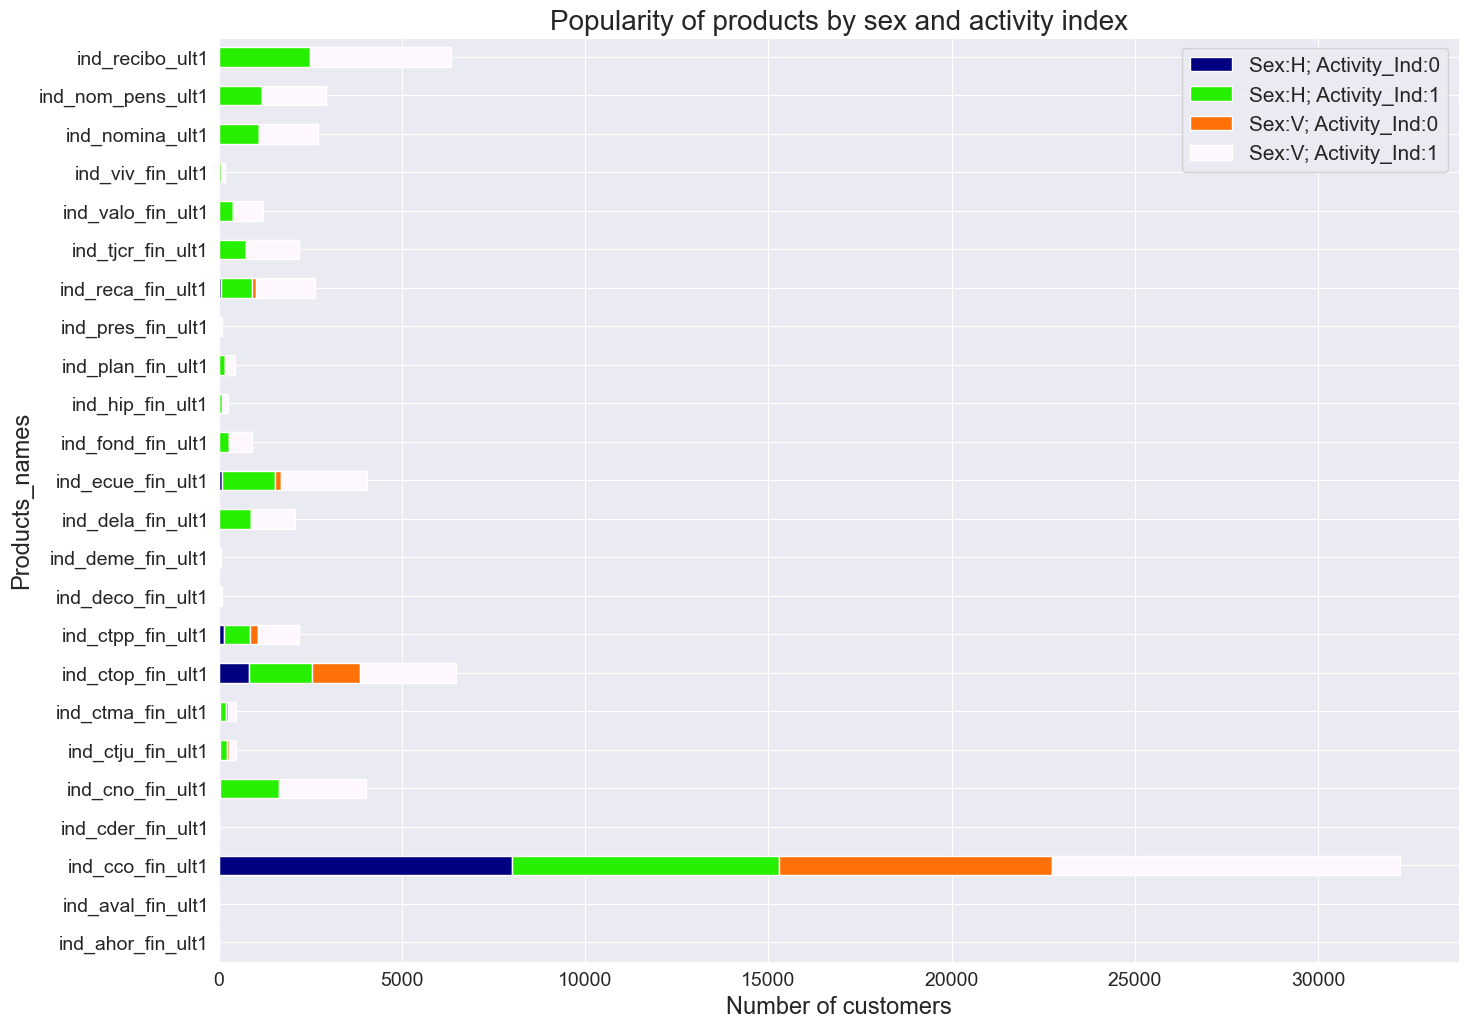

In [31]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_ncar')
plt.title('Popularity of products by sex and activity index', fontsize=20) 
plt.xlabel('Number of customers', fontsize=17) 
plt.ylabel('Products_names', fontsize=17) 
plt.legend(["Sex:H; Activity_Ind:0", "Sex:H; Activity_Ind:1", "Sex:V; Activity_Ind:0", 
            "Sex:V; Activity_Ind:1"], prop={'size':15}) 

we can see maximum customers belonged to current accounts

In [32]:
df_a = (df.groupby(pd.cut(df['renta'], [0,60000,120000,180000,240000, pd.np.inf], right=False))
                     .sum())
df_a['tot_products'].head()

renta
[0.0, 60000.0)           9087.0
[60000.0, 120000.0)     35466.0
[120000.0, 180000.0)    14583.0
[180000.0, 240000.0)     6407.0
[240000.0, inf)          6508.0
Name: tot_products, dtype: float64

In [33]:
# Let's drop the columns which are unnecessary for this step
df_a = df_a.loc[:, "ind_ahor_fin_ult1": "ind_recibo_ult1"]
df_a = df_a.T

In [34]:
df_a.head(8)

renta,"[0.0, 60000.0)","[60000.0, 120000.0)","[120000.0, 180000.0)","[180000.0, 240000.0)","[240000.0, inf)"
ind_ahor_fin_ult1,0.0,3.0,0.0,1.0,0.0
ind_aval_fin_ult1,0.0,0.0,0.0,0.0,0.0
ind_cco_fin_ult1,4873.0,17074.0,5768.0,2215.0,2296.0
ind_cder_fin_ult1,1.0,12.0,4.0,3.0,3.0
ind_cno_fin_ult1,488.0,1902.0,885.0,399.0,339.0
ind_ctju_fin_ult1,45.0,198.0,120.0,63.0,58.0
ind_ctma_fin_ult1,49.0,252.0,82.0,48.0,33.0
ind_ctop_fin_ult1,630.0,2996.0,1400.0,730.0,728.0


In [35]:
df["canal_entrada"].value_counts().head(10)

KHE    14760
KAT    11854
KFC    11301
KHQ     2213
KFA     1476
KHK      863
KHM      726
KHD      430
KHN      423
RED      302
Name: canal_entrada, dtype: int64

Most of the customers joined through three major channels
Since 6 out of 160 channels account for about 87.11% of the total number of customers attraction and to be able to visualze, we are going to exclude any channel has a contribution less than 1%.

In [36]:
# Let's extract the necessary columns for this step
df_a = df.loc[:, ['canal_entrada']].join(df.loc[:, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])

In [37]:
# Let's subset the data to keep only the records from the five major channels
subset = ["KHE", "KAT", "KFC", "KFA", "KHK"]
df_a = df_a.loc[df_a['canal_entrada'].isin(subset)]

In [38]:
df_a = df_a.groupby("canal_entrada").agg("sum")
df_a = df_a.T

In [39]:
df_a.head()

canal_entrada,KAT,KFA,KFC,KHE,KHK
ind_ahor_fin_ult1,2.0,1.0,1.0,0.0,0.0
ind_aval_fin_ult1,0.0,0.0,0.0,0.0,0.0
ind_cco_fin_ult1,6711.0,785.0,6168.0,12669.0,492.0
ind_cder_fin_ult1,15.0,1.0,5.0,0.0,0.0
ind_cno_fin_ult1,1590.0,180.0,1261.0,299.0,89.0


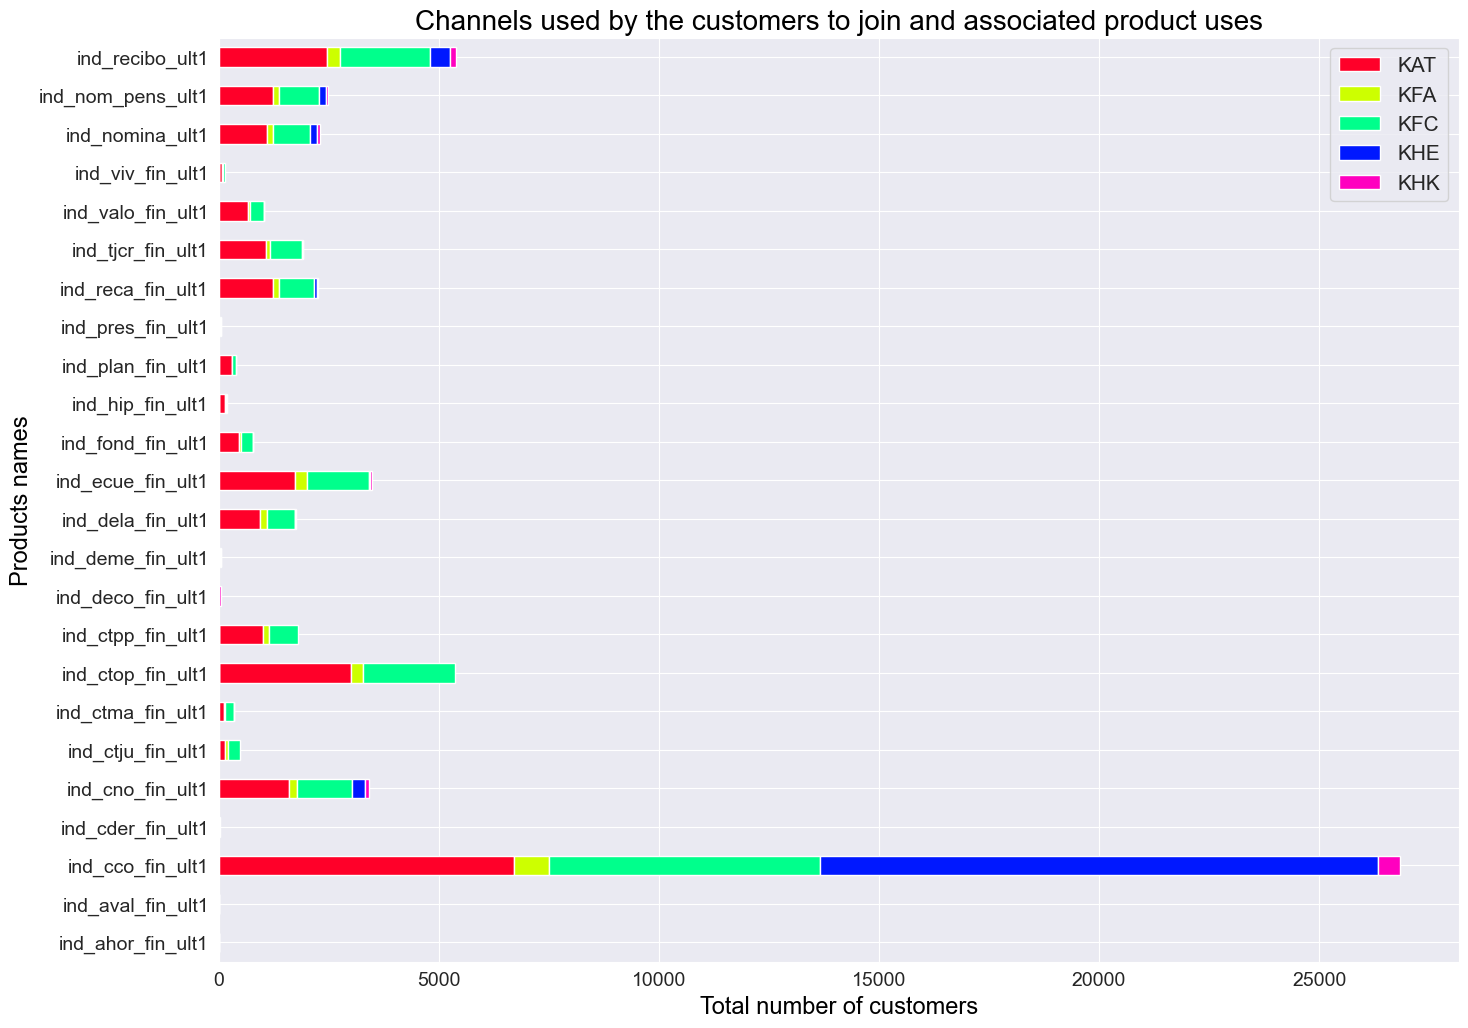

In [40]:
# Channels used by the customer to join and the purchased products
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_rainbow')
plt.title('Channels used by the customers to join and associated product uses', fontsize=20, color='black') 
plt.xlabel('Total number of customers', fontsize=17, color='black') 
plt.ylabel('Products names', fontsize=17, color='black') 
plt.legend(prop={'size':15}) 

In [64]:


# Filter rows where 'renta' is not null
filtered_df = df[df['renta'].notnull()]

# Group by 'nomprov' and calculate the median income
incomes = filtered_df.groupby("nomprov").agg(MedianIncome=('renta', median))

# Sort the DataFrame by MedianIncome
incomes.sort_values(by="MedianIncome", inplace=True)

# Reset the index
incomes.reset_index(inplace=True)

# Convert 'nomprov' to a categorical variable with the same categories as in the original DataFrame
incomes['nomprov'] = pd.Categorical(incomes['nomprov'], categories=df['nomprov'].unique(), ordered=False)
incomes.head()

,nomprov,MedianIncome
0,BIZKAIA,67183.980
1,AVILA,68041.725
2,BADAJOZ,68854.740
3,CIUDAD REAL,69181.200
4,"BALEARS, ILLES",71063.415


In [66]:
df.loc[df.ind_nomina_ult1.isnull(), "ind_nomina_ult1"] = 0
df.loc[df.ind_nom_pens_ult1.isnull(), "ind_nom_pens_ult1"] = 0

Last columns with missing values: 'ind_empleado', 'pais_residencia', 'sexo', 'ult_fec_cli_1t', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp', 'canal_entrada', 'indfall', 'segmento'

In [67]:
string_data = df.select_dtypes(include=["object"])
missing_columns = [col for col in string_data if string_data[col].isnull().any()]
for col in missing_columns:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
del string_data

In [68]:
df.isnull().any()

index                    False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes              False
tiprel_1mes              False
indresi                  False
indext                   False
canal_entrada            False
indfall                  False
tipodom                  False
cod_prov                 False
nomprov                  False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco

In [69]:
#Convert the products feature columns into integer values
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)

In [70]:
df.dtypes

index                      int64
fecha_dato                object
ncodpers                   int64
ind_empleado              object
pais_residencia           object
sexo                      object
age                        int64
fecha_alta                object
ind_nuevo                 object
antiguedad               float64
indrel                   float64
indrel_1mes              float64
tiprel_1mes               object
indresi                   object
indext                    object
canal_entrada             object
indfall                   object
tipodom                  float64
cod_prov                 float64
nomprov                   object
ind_actividad_cliente    float64
renta                    float64
segmento                  object
ind_ahor_fin_ult1          int64
ind_aval_fin_ult1          int64
ind_cco_fin_ult1           int64
ind_cder_fin_ult1          int64
ind_cno_fin_ult1           int64
ind_ctju_fin_ult1          int64
ind_ctma_fin_ult1          int64
ind_ctop_f

# Training the model

In [71]:

usecols = ['ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']
       
df_train = pd.read_csv("train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str},usecols=usecols)
df_test = pd.read_csv("train_ver2.csv",dtype={"sexo":str,
                                          "ind_nuevo":str,
                                              "ult_fec_cli_1t":str,
                                              "indext":str},usecols=usecols)

sample = pd.read_csv('sample_submission.csv')

df_train = df_train.drop_duplicates(['ncodpers'], keep='last')
#df_test = df_test.drop_duplicates(['ncodpers'], keep='last')
df_train.fillna(0, inplace=True)
#df_test.fillna(0, inplace=True)

#We take unique_ids and unique fecha_datos just to play forward.
unique_ids   = pd.Series(df_train["ncodpers"].unique())

df_train.count()
unique_ids.count()
limit_people = 10000
unique_id    = unique_ids.sample(n=limit_people)
df_train           = df_train[df_train.ncodpers.isin(unique_id)]

In [72]:
models = {}
id_preds = defaultdict(list)
ids = df_train['ncodpers'].values

#Delete in final model (Done before)
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)
# -------------------------------------------------------------------------------------------#    
for c in df_train.columns:
    if c != 'ncodpers':
        #print(c)
        y_train = df_train[c]
        x_train = df_train.drop([c, 'ncodpers'], 1)
        
        
for c in df_test.columns:
    if c != 'ncodpers':
        #print(c)
        x_test = df_test.drop([c, 'ncodpers'], 1) 
        x_test = x_test.fillna(method='ffill')

In [73]:
models = [('lr',LogisticRegression()),('rfr',RandomForestClassifier()),('etr',ExtraTreesClassifier()),
         ('br',BaggingClassifier()),('gbr',GradientBoostingClassifier()),('mlp',MLPClassifier()),('xgb',XGBClassifier()),('knn',KNeighborsClassifier())]

In [74]:
#Making function for making best 2 models for further hyperparameter tuning
def basic_model_selection(x,y,model,z):
    scores=[]
    names = []
    for i , j in model:
        clf = j
        clf.fit(x,y)
        p_train = clf.predict_proba(x)[:,1]
        for id,p in zip(ids,p_train):
            id_preds[id].append(p)
        names.append(i)
        scores.append(roc_auc_score(y,p_train))
    for k in range(len(scores)):
        print(names[k],scores[k])

In [75]:
basic_model_selection(x_train,y_train,models,ids)

lr 0.8695675913811977
rfr 0.8849698288521612
etr 0.888083865110939
br 0.8849714753602295
gbr 0.8759478991447058
mlp 0.8813251719933427
xgb 0.8824183643499853
knn 0.8363063484011072


In [76]:
def model_parameter_tuning(x,y,model,parameters,cross_folds,ids):
    model_grid = GridSearchCV(model,
                        parameters,
                        cv = cross_folds,
                        n_jobs = -1,
                        verbose=True)
    model_grid.fit(x,y)
    y_predicted = model_grid.predict_proba(x)[:,1]
    for id, p in zip(ids,y_predicted):
        id_preds[id].append(p)
    print(roc_auc_score(y,y_predicted))    
    print(model_grid.best_params_)
#defining function for hyper parameter tuning and using ROC_AUC score as my metric
    

In [77]:
parameters_mlp = {'hidden_layer_sizes':[(100,200,100),(200,200)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['adam'],
    'alpha': [0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
                   }
parameters_etr = {
              'n_estimators': [70,80,50,45]
                  }
# Defining the useful parameters for parameter tuning
# to get the optimum output

In [78]:
mlp = MLPClassifier()
etr = ExtraTreesClassifier()

In [79]:
model_parameter_tuning(x_train,y_train,etr,parameters_etr,2,ids)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
0.888083865110939
{'n_estimators': 70}


In [80]:
model_parameter_tuning(x_train,y_train,mlp,parameters_mlp,2,ids)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8740852535177422
{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (200, 200), 'learning_rate': 'adaptive', 'solver': 'adam'}


We are going to use EXtra Tree Classifier as the final model


In [81]:
#print(id_preds)
active_ = {}
for val in df_train.values:
    val = list(val)
    id = val.pop(0) ## pop ncodpers (customer id)
    ## active columna
    active  = [c[0] for c in zip(df_train.columns[1:],val) if c[1] > 0]
    active_[id] = active
    
train_preds = {}
for id,val in id_preds.items():
    preds = [i[0] for i in sorted([i for i in zip(df_train.columns[1:],val) if i[0] not in active_[id]], key=lambda i:i [1], reverse=True)[:3]]
    train_preds[id] = preds


In [82]:
sample.values[0:5]
# This is how the predictions should look like

array([[103709, 'ind_tjcr_fin_ult1'],
       [103710, 'ind_tjcr_fin_ult1'],
       [103714, 'ind_tjcr_fin_ult1'],
       [103717, 'ind_tjcr_fin_ult1'],
       [103718, 'ind_tjcr_fin_ult1']], dtype=object)

In [131]:
train_preds

{1049527: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1055000: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1054812: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1042617: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1046704: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1064553: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1069356: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1068028: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1062966: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1060516: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1023318: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1023436: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1024547: ['ind_ctop_fin_ult1', 'ind_ahor_fin_ult1', 'ind_cno_fin_ult1'],
 1029135: ['ind_ctop_fin_ult1', 'ind_a

In [132]:
sample.to_csv('recommendation.csv',index=False)

In [133]:
test_preds

[]

In [134]:
train_preds
train = pd.DataFrame.from_dict(train_preds,orient='index')
train

,0,1,2
1049527,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1
1055000,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1
1054812,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1
1042617,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1
1046704,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1
...,...,...,...
1171408,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1
1171013,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1
1171629,ind_ahor_fin_ult1,ind_cno_fin_ult1,ind_deco_fin_ult1
1172263,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1


In [135]:
df = pd.DataFrame.from_dict(train_preds,orient='index')

In [136]:
df['Rec'] = '['+df[0]+' ,'+ df[1] + ' ,' + df[2]+']'
df

,0,1,2,Rec
1049527,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1055000,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1054812,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1042617,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1046704,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
...,...,...,...,...
1171408,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1171013,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1171629,ind_ahor_fin_ult1,ind_cno_fin_ult1,ind_deco_fin_ult1,"[ind_ahor_fin_ult1 ,ind_cno_fin_ult1 ,ind_deco..."
1172263,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."


In [137]:
columns_to_drop = [0,1,2]
df.drop(columns = columns_to_drop)

,Rec
1049527,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1055000,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1054812,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1042617,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1046704,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
...,...
1171408,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1171013,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."
1171629,"[ind_ahor_fin_ult1 ,ind_cno_fin_ult1 ,ind_deco..."
1172263,"[ind_ctop_fin_ult1 ,ind_ahor_fin_ult1 ,ind_cno..."


In [138]:
Final_df = pd.concat([train,df],axis = 0 ,ignore_index = True)
Final_df.head(1000)

,0,1,2,Rec
0,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,NaN
1,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,NaN
2,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,NaN
3,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,NaN
4,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,NaN
...,...,...,...,...
995,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,NaN
996,ind_cder_fin_ult1,ind_ctpp_fin_ult1,ind_aval_fin_ult1,NaN
997,ind_ahor_fin_ult1,ind_cno_fin_ult1,ind_deco_fin_ult1,NaN
998,ind_ctop_fin_ult1,ind_ahor_fin_ult1,ind_cno_fin_ult1,NaN
